In [70]:
#!pip install xlrd
#!pip install openpyxl
#!pip install pandas

import numpy as np
import pandas as pd

import os

from torchvision import models
from torchvision import transforms
from torch import nn

import cv2
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, Dataset

In [2]:
"""
1. image path 지정
2. 모델 불러오기
3. probability 얻기
4. probability를 prediction label로 변환하기
5. 결과 저장
"""

'\n1. image path 지정\n2. 모델 불러오기\n3. probability 얻기\n4. label로 변환하기\n5. 결과 출력하기\n6. grad-cam 결과 출력하기\n'

## 0. Functions

In [49]:
class VGG16(nn.Module):
    def __init__(self, pretrained, freeze):
        super(VGG16, self).__init__()
        self.base = models.vgg16_bn(pretrained=pretrained)
        self.base.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.base.classifier = nn.Linear(in_features=512, out_features=1, bias=True).requires_grad_(not freeze)
        
    def forward(self, x):
        x = self.base(x)
        return x
    
def GetLoader(transform, x, y, batch = 32, test=True):
    dataset = TMJImageDataset(x,y,transform=transform)
    return DataLoader(dataset, batch_size = batch, shuffle=(not test), num_workers=0)
        
class TMJImageDataset(Dataset):
    def __init__(self, x, y, transform):
        self.x = x
        self.y = y
        self.transform = transform
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        x = self.x[index, :] 
        y = self.y[index]              
        
        if self.transform is None or len(self.transform) == 0:
            x = transforms.ToTensor()(x)
            return x, y
        else:
            transform = transforms.Compose(self.transform)
            pli = Image.fromarray(np.uint8(x)).convert('RGB')
            x = transform(pli)
            x = np.array(x)
            x = transforms.ToTensor()(x)
            return x,y
        
def decision_func(proba, threshold=0.5):
    prediction = []
    for p in proba:
        if p >= threshold:
            prediction.append(1)
        else:
            prediction.append(0)
    
    return np.asarray(prediction)        

## 1. Loading images

In [35]:
image_root = './Dataset/Test_image/'
MRIs = ['PD', 'T2']
categorys = ['image', 'pt_no', 'label']

In [38]:
data = {}

for MRI in MRIs:
    data[MRI] = {}
    MRI_image_root = os.path.join(image_root, MRI)
    images = os.listdir(MRI_image_root)
    for category in categorys: data[MRI][category] = []
            
    for image in images:
        pt_no,side,age,sex,label = image.split('_') 
        pt_no,age,label = int(pt_no), int(age), int(label[0])

        image_path = os.path.join(MRI_image_root,image)
        
        reshaped_image = cv2.resize(cv2.imread(image_path, 0),(140,140))
        reshaped_image = np.dstack((reshaped_image,reshaped_image,reshaped_image))

        data[MRI]['image'].append(reshaped_image)
        data[MRI]['pt_no'].append(pt_no)
        data[MRI]['label'].append(label)
    data[MRI]['image'], data[MRI]['label']= np.array(data[MRI]['image']), np.array(data[MRI]['label']).reshape(-1,1)

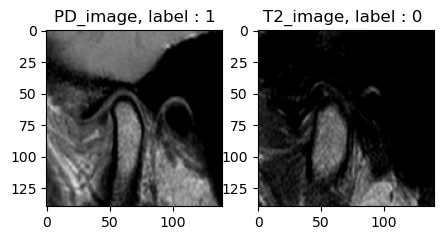

In [25]:
example_PD_image_path = './Dataset/Test_image/PD/10678885_L_37_F_1.png'
PD_label = torch.tensor(int(PD_image_path.split('_')[-1][0]))

example_T2_image_path = './Dataset/Test_image/T2/10928594_L_49_F_0.png'
T2_label = torch.tensor(int(T2_image_path.split('_')[-1][0]))

PD_image = cv2.resize(cv2.imread(example_PD_image_path),(140,140))
T2_image = cv2.resize(cv2.imread(example_T2_image_path),(140,140))

plt.figure(figsize = (5,2.5))
plt.subplot(1,2,1)
plt.title(f'PD_image, label : {PD_label}')
plt.imshow(PD_image)

plt.subplot(1,2,2)
plt.title(f'T2_image, label : {T2_label} ')
plt.imshow(T2_image)

plt.show()

## 2. Loading VGG16 Model 

In [15]:
PD_model_parameter_path = './Model_for_effusion/vgg16_PD_finetuning.pt'
T2_model_parameter_path = './Model_for_effusion/vgg16_T2_finetuning.pt'

In [16]:
PD_model = VGG16(True, False)
PD_model.load_state_dict(torch.load(PD_model_parameter_path))
PD_model.eval()

T2_model = VGG16(True, False)
T2_model.load_state_dict(torch.load(T2_model_parameter_path))
T2_model.eval()

print('Model loaded')

/home/bis/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bis/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model loaded


## 3.Obtaining output from the loaded model

In [43]:
device = torch.device('cuda:1')
threshold = {}
threshold['PD'] = 0.57291967
threshold['T2'] = 0.41736078

PD_loader = GetLoader([], data['PD']['image'], data['PD']['label'], batch=len(PD_labels), test=True)
T2_loader = GetLoader([], data['T2']['image'], data['T2']['label'], batch=len(T2_labels), test=True)

In [63]:
result = {}
sig = torch.nn.Sigmoid()
for MRI in MRIs:
    result[MRI] = {}
    
    if MRI == 'PD': 
        loader = PD_loader
        model = PD_model.to(device)
    if MRI == 'T2': 
        loader = T2_loader
        model = T2_model.to(device)

    with torch.no_grad():
        for image, label in loader:
            image, label = image.to(device), label.to(device)
            logit = model(image)
            proba, label = sig(logit), label.float()
    result[MRI]['proba'], result[MRI]['logit'], result[MRI]['label'] = proba.cpu().numpy(), logit.cpu().numpy(), label.cpu().numpy()                
    result[MRI]['predict_label'] = decision_func(result[MRI]['proba'], threshold=threshold[MRI])

## 4. Saving the output as xlsx file

In [75]:
PD_xlsx = {}
PD_xlsx['pt_no'] = data['PD']['pt_no']
PD_xlsx['label'] = data['PD']['label'][:,0]
PD_xlsx['prediction'] = result['PD']['predict_label']

T2_xlsx = {}
T2_xlsx['pt_no'] = data['T2']['pt_no']
T2_xlsx['label'] = data['T2']['label'][:,0]
T2_xlsx['prediction'] = result['T2']['predict_label']

PD_df = pd.DataFrame(PD_xlsx)
T2_df = pd.DataFrame(T2_xlsx)

In [79]:
PD_df.to_excel("./PD_output.xlsx", index=False)
T2_df.to_excel("./T2_output.xlsx", index=False)